# Introduction


For gold ETF, we choose SPDR Gold Shares ETF, with symbol GLD.

For equity ETF outside US, we choose iShares MSCI India ETF, with symbol INDA.

For bitcoin, we choose Grayscale Bitcoin Trust, with symbol GBTC

All prices are in USD Data source: https://finance.yahoo.com

# Packages and Libraries

In [1]:
import arch
import yfinance as yf
import pandas as pd
import numpy as np
from array import array
from scipy.stats import kurtosis
from sklearn.cluster import MeanShift
from copulalib.copulalib import Copula
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import VECM
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Building Trading Strategies During COVID

# 1. Data Importing

In [2]:
gold_df = yf.download("GLD", start="2020-4-1", end="2020-12-31")
india_df = yf.download("INDA", start="2020-4-1", end="2020-12-31")
bitcoin_df= yf.download("GBTC", start="2020-4-1", end="2020-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-31,151.360001,151.800003,147.970001,148.050003,148.050003,13319500
2020-04-01,148.199997,150.080002,147.850006,149.449997,149.449997,11827400
2020-04-02,151.199997,152.500000,150.699997,151.899994,151.899994,9188300
2020-04-03,152.229996,153.089996,151.660004,152.649994,152.649994,8469100
2020-04-06,154.160004,157.220001,153.960007,156.880005,156.880005,14739300


In [4]:
gold_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,175.100006,176.210007,175.059998,175.649994,175.649994,6542800
2020-12-24,175.550003,176.369995,175.509995,176.350006,176.350006,3695400
2020-12-28,177.259995,177.910004,175.630005,175.710007,175.710007,7778700
2020-12-29,176.250000,176.970001,175.570007,176.350006,176.350006,5983700
2020-12-30,176.440002,177.720001,176.440002,177.699997,177.699997,5914000


In [5]:
india_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-31,24.090000,24.469999,23.870001,24.110001,24.002792,10298500
2020-04-01,22.830000,22.910000,22.330000,22.330000,22.230707,7727500
2020-04-02,22.709999,23.150000,22.480000,22.910000,22.808126,9119300
2020-04-03,22.610001,22.690001,21.920000,22.010000,21.912128,4746600
2020-04-06,22.990000,23.680000,22.920000,23.670000,23.564747,8111000


In [6]:
india_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,38.990002,39.029999,38.919998,38.959999,38.923748,4906100
2020-12-24,39.230000,39.369999,39.230000,39.360001,39.323380,2924800
2020-12-28,39.759998,39.779999,39.580002,39.720001,39.683044,4541800
2020-12-29,39.840000,39.980000,39.740002,39.869999,39.832901,6577000
2020-12-30,40.110001,40.220001,40.060001,40.099998,40.062687,6492800


In [7]:
bitcoin_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-31,7.070,7.14,6.94,7.120,7.120,2675500
2020-04-01,6.800,6.90,6.41,6.495,6.495,4274800
2020-04-02,7.000,7.87,6.98,7.720,7.720,7980600
2020-04-03,7.940,7.94,7.25,7.480,7.480,3059800
2020-04-06,7.824,8.06,7.71,7.950,7.950,4910400


In [8]:
bitcoin_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,30.500000,30.850000,28.820000,28.879999,28.879999,11054700
2020-12-24,28.700001,28.709999,26.450001,27.350000,27.350000,12591200
2020-12-28,33.330002,33.340000,30.120001,30.450001,30.450001,19499400
2020-12-29,31.110001,31.150000,28.500000,30.080000,30.080000,16651800
2020-12-30,31.299999,33.000000,31.000000,32.900002,32.900002,18116500


# 2. Data Processing

In [9]:
gold_df["Daily Return"] = gold_df["Adj Close"].pct_change(1)
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-03-31,151.360001,151.800003,147.970001,148.050003,148.050003,13319500,NaN
2020-04-01,148.199997,150.080002,147.850006,149.449997,149.449997,11827400,0.009456
2020-04-02,151.199997,152.500000,150.699997,151.899994,151.899994,9188300,0.016393
2020-04-03,152.229996,153.089996,151.660004,152.649994,152.649994,8469100,0.004937
2020-04-06,154.160004,157.220001,153.960007,156.880005,156.880005,14739300,0.027711


In [10]:
india_df["Daily Return"] = india_df["Adj Close"].pct_change(1)
india_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-03-31,24.090000,24.469999,23.870001,24.110001,24.002792,10298500,NaN
2020-04-01,22.830000,22.910000,22.330000,22.330000,22.230707,7727500,-0.073828
2020-04-02,22.709999,23.150000,22.480000,22.910000,22.808126,9119300,0.025974
2020-04-03,22.610001,22.690001,21.920000,22.010000,21.912128,4746600,-0.039284
2020-04-06,22.990000,23.680000,22.920000,23.670000,23.564747,8111000,0.075420


In [11]:
bitcoin_df["Daily Return"] = bitcoin_df["Adj Close"].pct_change(1)
bitcoin_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-03-31,7.070,7.14,6.94,7.120,7.120,2675500,NaN
2020-04-01,6.800,6.90,6.41,6.495,6.495,4274800,-0.087781
2020-04-02,7.000,7.87,6.98,7.720,7.720,7980600,0.188607
2020-04-03,7.940,7.94,7.25,7.480,7.480,3059800,-0.031088
2020-04-06,7.824,8.06,7.71,7.950,7.950,4910400,0.062834


# 3. Data Summaries.  Extreme Values

# Returns from January

In [12]:
GOLD_DF = yf.download("GLD", start="2020-1-1", end="2020-12-31")
INDIA_DF = yf.download("INDA", start="2020-1-1", end="2020-12-31")
BITCOIN_DF= yf.download("GBTC", start="2020-1-1", end="2020-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
GOLD_DF["Daily Return"] = GOLD_DF["Adj Close"].pct_change(1)
GOLD_DF.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-12-31,143.309998,143.600006,142.800003,142.899994,142.899994,5313500,NaN
2020-01-02,143.860001,144.210007,143.399994,143.949997,143.949997,7733800,0.007348
2020-01-03,145.750000,146.320007,145.399994,145.860001,145.860001,12272800,0.013269
2020-01-06,148.440002,148.479996,146.949997,147.389999,147.389999,14403300,0.010490
2020-01-07,147.570007,148.139999,147.429993,147.970001,147.970001,7978500,0.003935


In [14]:
INDIA_DF["Daily Return"] = INDIA_DF["Adj Close"].pct_change(1)
INDIA_DF.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-12-31,35.009998,35.169998,34.959999,35.150002,34.993702,2820100,NaN
2020-01-02,35.480000,35.590000,35.410000,35.580002,35.421791,3880500,0.012233
2020-01-03,35.130001,35.160000,34.970001,34.980000,34.824455,4085000,-0.016864
2020-01-06,34.439999,34.619999,34.369999,34.570000,34.416275,4516100,-0.011721
2020-01-07,34.520000,34.630001,34.490002,34.520000,34.366501,2940200,-0.001446


In [15]:
BITCOIN_DF["Daily Return"] = BITCOIN_DF["Adj Close"].pct_change(1)
BITCOIN_DF.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-12-31,8.47,8.47,8.15,8.19,8.19,3093800,NaN
2020-01-02,8.18,8.34,7.91,7.98,7.98,3377600,-0.025641
2020-01-03,8.28,8.59,8.13,8.59,8.59,3858800,0.076441
2020-01-06,8.98,9.03,8.92,8.99,8.99,3450500,0.046566
2020-01-07,9.48,10.10,9.26,10.10,10.10,7787400,0.123471


# Kurtosis from January

In [16]:
kurtosis(GOLD_DF["Daily Return"].dropna())

3.4339654102514876

In [17]:
kurtosis(INDIA_DF["Daily Return"].dropna())

9.130359470180705

In [18]:
kurtosis(BITCOIN_DF["Daily Return"].dropna())

2.8001670933759515

# Extreme Values (Outliers Clustering)

In [19]:
GOLD_EXT= pd.concat([GOLD_DF["Daily Return"] , GOLD_DF["Adj Close"]], axis=1, keys=['Close', 'Daily Return']).fillna(0).values
INDIA_EXT= pd.concat([INDIA_DF["Daily Return"] , INDIA_DF["Adj Close"]], axis=1, keys=['Close', 'Daily Return']).fillna(0).values
BITCOIN_EXT= pd.concat([BITCOIN_DF["Daily Return"] , BITCOIN_DF["Adj Close"]], axis=1, keys=['Close', 'Daily Return']).fillna(0).values

In [20]:
GOLD_CLUST = MeanShift(bandwidth=2).fit(GOLD_EXT)
INDIA_CLUST = MeanShift(bandwidth=2).fit(INDIA_EXT)
BITCOIN_CLUST = MeanShift(bandwidth=2).fit(BITCOIN_EXT)

In [21]:
GOLD_CLUST.labels_

array([10, 10,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  8,  8,
        5,  5,  9,  5,  5,  5,  2,  8,  5,  5,  9,  9,  9,  5,  5,  2, 10,
       10, 10, 10, 13, 13,  2,  5,  8,  5,  5,  5,  2,  8,  8,  5,  9,  9,
        5,  9,  1,  1,  1,  1,  9,  1,  9,  1,  1,  1,  1,  1,  1,  9,  1,
        1,  1,  9,  1,  1,  1,  1,  1,  1,  7,  1,  7,  7,  1,  1,  1,  1,
        1,  1,  7,  1,  1,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  7,
        7,  6,  7,  7,  6,  6,  6,  6,  6,  6,  6,  4,  4,  4,  4,  4,  4,
        6,  4,  4,  4,  0,  0,  0,  3,  3,  3,  3,  3,  3, 11, 11, 12, 11,
       11,  3,  0,  3,  3, 11, 11,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  0,  0,  0,  0,  0,  0,
        3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [22]:
INDIA_CLUST.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [23]:
BITCOIN_CLUST.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4], dtype=int64)

# 4. Data Comparison { Copulas }

****************************************
NON_GAUSSIAN COPULA FOR GOLD DATA
****************************************
****************************************


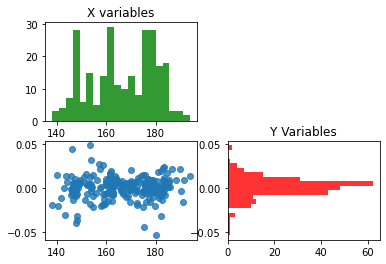

In [24]:
def CopulaGraph():
    x = (GOLD_DF["Adj Close"]).fillna(0).values
    y = (GOLD_DF['Daily Return']).fillna(0).values
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x,bins=20,color='green',alpha=0.8,align='mid')
    plt.title('X variables')
    fig.add_subplot(2,2,3)
    plt.scatter(x,y,marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y,bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('Y Variables')
    print("*"*40)
    print("NON_GAUSSIAN COPULA FOR GOLD DATA")
    print("*"*40)
    print("*"*40)
    plt.show()

def Copulas():
    x = array((GOLD_DF["Adj Close"]).fillna(0).values.tolist())
    y = array((GOLD_DF['Daily Return']).fillna(0).values.tolist())
    fig = plt.figure()

    clayton = Copula(x,y,family='clayton')
    uc,vc = clayton.generate_uv(1000)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.',color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton copula')
    plt.show()
CopulaGraph()

****************************************
NON_GAUSSIAN COPULA FOR BITCOIN DATA
****************************************
****************************************


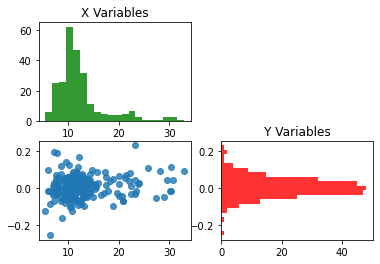

In [25]:
def CopulaGraph():
    x = (BITCOIN_DF["Adj Close"]).fillna(0).values
    y = (BITCOIN_DF['Daily Return']).fillna(0).values
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x,bins=20,color='green',alpha=0.8,align='mid')
    plt.title('X Variables')
    fig.add_subplot(2,2,3)
    plt.scatter(x,y,marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y,bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('Y Variables')
    print("*"*40)
    print("NON_GAUSSIAN COPULA FOR BITCOIN DATA")
    print("*"*40)
    print("*"*40)
    plt.show()

def Copulas():
    x = array((BITCOIN_DF["Adj Close"]).fillna(0).values.tolist())
    y = array((BITCOIN_DF['Daily Return']).fillna(0).values.tolist())
    fig = plt.figure()

    clayton = Copula(x,y,family='clayton')
    uc,vc = clayton.generate_uv(1000)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.',color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton copula')
    plt.show()
CopulaGraph()

# 5. Category 1 Model

In [26]:
df_names = {0: "GOLD DATA", 1: "INDIA DATA", 2: "BITCOIN"}
dfs = [GOLD_DF, INDIA_DF, BITCOIN_DF]
def get_data(df, month_start, month_end, column=None):
    data = df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")]
    if column:
        data = data[column]
    return data
def summarize_data(df):
    data = get_data(df, 3, 12, "Adj Close")
    moving_avg = data.rolling(20, min_periods=1).mean()
    return get_data(moving_avg, 4, 12)
def get_data(df, month_start, month_end, column):
    return df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")][column]
def fit_arima(data, exog= None):
    model = ARIMA(data, exog=exog, order=(2,0,2))
    model_fit = model.fit()
    return model_fit
def fit_garch(data, garch_type="GARCH"):
    if garch_type == "TARCH":
        garch = arch.arch_model(data, vol='TGARCH', p=1, o=1, q=1, power=1)
    else:
        garch = arch.arch_model(data, vol=garch_type, p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())
    if garch_type != "FIGARCH":
        omega = garch_fitted.params["omega"]
        alpha = garch_fitted.params["alpha[1]"]
        beta = garch_fitted.params["beta[1]"]
        print(f"Unconditional variance: {omega/(1 - alpha - beta)}")
    return garch_fitted

# Data Estimation and Performance Evaluation

In [27]:
GOLD_Q2 = get_data(GOLD_DF, 4, 6, "Daily Return")
GOLD_Q3 = get_data(GOLD_DF, 7, 9, "Daily Return")
GOLD_Q4 = get_data(GOLD_DF, 10, 12, "Daily Return")


INDIA_Q2 = get_data(INDIA_DF, 4, 6, "Daily Return")
INDIA_Q3 = get_data(INDIA_DF, 7, 9, "Daily Return")
INDIA_Q4 = get_data(INDIA_DF, 10, 12, "Daily Return")

BITCOIN_Q2 = get_data(BITCOIN_DF, 4, 6, "Daily Return")
BITCOIN_Q3 = get_data(BITCOIN_DF, 7, 9, "Daily Return")
BITCOIN_Q4 = get_data(BITCOIN_DF, 10, 12, "Daily Return")

In [28]:
GOLD_Q2.shape

(41,)

In [29]:
INDIA_Q3.shape

(43,)

In [30]:
BITCOIN_Q4.shape

(42,)

In [31]:
model = fit_arima(INDIA_Q2)
return_pred = model.predict(start=INDIA_Q2.shape[0], end=INDIA_Q2.shape[0] + INDIA_Q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(INDIA_Q3* signal + 1) - 1
return_q3

C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

0.14989665893405557

In [32]:
model = fit_arima(INDIA_Q3)
return_pred = model.predict(start=INDIA_Q3.shape[0], end=INDIA_Q3.shape[0] + INDIA_Q4.shape[0] - 1).values
signal = np.where(return_pred >0, 1, -1)
return_q4 = np.product(INDIA_Q4 * signal + 1) - 1
return_q4

C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. U

0.06651242709821337

In [33]:
(1 + return_q3) * (1 + return_q4) - 1

0.22637907663188606

# 6. Category 2 Model

In [34]:
model = fit_arima(GOLD_Q2, INDIA_Q2)
return_pred = model.predict(exog=INDIA_Q3, start=GOLD_Q2.shape[0], end=GOLD_Q2.shape[0] + GOLD_Q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(GOLD_Q3 * signal + 1) - 1
return_q3

C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

0.09906197236515357

In [35]:
model = fit_arima(GOLD_Q3, INDIA_Q3)
return_pred = model.predict(exog=INDIA_Q4, start=GOLD_Q3.shape[0], end=GOLD_Q3.shape[0] + GOLD_Q4.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q4 = np.product(GOLD_Q4 * signal + 1) - 1
return_q4

C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

-0.011220591357070764

In [36]:
(1 + return_q3) * (1 + return_q4) - 1

0.08672984709714804

# 7. Category 3 Model

In [37]:
model = fit_arima(BITCOIN_Q2, pd.concat([INDIA_Q2, GOLD_Q2], axis=1))
return_pred = model.predict(exog=pd.concat([INDIA_Q3, GOLD_Q3], axis=1), start=BITCOIN_Q2.shape[0], end=BITCOIN_Q2.shape[0] + BITCOIN_Q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(BITCOIN_Q3 * signal + 1) - 1
return_q3

C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

1.5162649880292265

In [38]:
model = fit_arima(BITCOIN_Q3, pd.concat([INDIA_Q3, GOLD_Q3], axis=1))
return_pred = model.predict(exog=pd.concat([INDIA_Q4, GOLD_Q4], axis=1), start=BITCOIN_Q3.shape[0], end=BITCOIN_Q3.shape[0] + BITCOIN_Q4.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q4 = np.product(BITCOIN_Q4 * signal + 1) - 1
return_q4

C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\M1\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

0.1732775319466513

In [39]:
(1 + return_q3) * (1 + return_q4) - 1

1.952277174878701

# Existance of Cointegration

In [40]:
GOLD_DATA = get_data(GOLD_DF, 4, 6, "Daily Return").values
INDIA_DATA = get_data(INDIA_DF, 4, 6, "Daily Return").values
BITCOIN_DATA = get_data(BITCOIN_DF, 4, 6, "Daily Return").values

In [41]:
coint(GOLD_DATA, np.array([INDIA_DATA, BITCOIN_DATA]).T)

(-6.565747916371132,
 4.322682923961853e-07,
 array([-4.67463073, -3.96108528, -3.60986125]))

In [42]:
coint(INDIA_DATA, np.array([GOLD_DATA, BITCOIN_DATA]).T)

(-4.988541436908666,
 0.0008060777558728423,
 array([-4.67463073, -3.96108528, -3.60986125]))

In [43]:
coint(BITCOIN_DATA, np.array([GOLD_DATA, INDIA_DATA]).T)

(-5.454046045702774,
 0.00011149058020115203,
 array([-4.67463073, -3.96108528, -3.60986125]))

# VECM Model

In [44]:
data_q2 = np.array([GOLD_DATA, INDIA_DATA, BITCOIN_DATA]).T
model = VECM(data_q2, coint_rank=1)
vecm_res = model.fit()
res = vecm_res.predict(steps=43)
row_sums = res.sum(axis=1)
weights = res / row_sums[:, np.newaxis]
weights

array([[0.12314599, 0.46467365, 0.41218037],
       [0.16420781, 0.28384783, 0.55194436],
       [0.14118757, 0.32668707, 0.53212536],
       [0.15574039, 0.37318813, 0.47107148],
       [0.14778397, 0.37228896, 0.47992707],
       [0.15183342, 0.35621036, 0.49195622],
       [0.14939737, 0.35490377, 0.49569886],
       [0.15073002, 0.35876472, 0.49050526],
       [0.15009218, 0.35997075, 0.48993708],
       [0.15041549, 0.35898925, 0.49059526],
       [0.15023708, 0.35848538, 0.49127753],
       [0.1503176 , 0.3587085 , 0.4909739 ],
       [0.15028821, 0.35886374, 0.49084804],
       [0.15029962, 0.35884583, 0.49085455],
       [0.15029638, 0.35878171, 0.49092192],
       [0.15029473, 0.35878893, 0.49091634],
       [0.15029761, 0.35879991, 0.49090248],
       [0.15029518, 0.35880535, 0.49089947],
       [0.15029715, 0.35879925, 0.49090359],
       [0.15029558, 0.3587992 , 0.49090522],
       [0.15029669, 0.35879936, 0.49090395],
       [0.15029596, 0.35880039, 0.49090365],
       [0.

In [45]:
GOLD_DATA = get_data(GOLD_DF, 7, 9, "Daily Return").values
INDIA_DATA = get_data(INDIA_DF, 7, 9, "Daily Return").values
BITCOIN_DATA = get_data(BITCOIN_DF, 7, 9, "Daily Return").values
data_q3 = np.array([GOLD_DATA, INDIA_DATA, BITCOIN_DATA]).T

return_q3 = weights * data_q3
total_return_q3 = return_q3.sum(axis=1)
portfolio_return_q3 = np.product(total_return_q3 + 1) - 1
portfolio_return_q3

0.274253294322615

# Cointegrations

In [46]:
coint(GOLD_DATA, np.array([INDIA_DATA, BITCOIN_DATA]).T)

(-6.696293904299751,
 2.1032695070960866e-07,
 array([-4.6556178 , -3.95031996, -3.60224723]))

In [47]:
coint(INDIA_DATA, np.array([GOLD_DATA, BITCOIN_DATA]).T)

(-3.3064742898341692,
 0.13647697202193737,
 array([-4.6556178 , -3.95031996, -3.60224723]))

In [48]:
coint(BITCOIN_DATA, np.array([GOLD_DATA, INDIA_DATA]).T)

(-9.705465731863168,
 8.051645340566347e-16,
 array([-4.6556178 , -3.95031996, -3.60224723]))

In [49]:
model = VECM(data_q3, coint_rank=1)
vecm_res = model.fit()
res = vecm_res.predict(steps=42)
row_sums = res.sum(axis=1)
weights = res / row_sums[:, np.newaxis]
weights

array([[ 0.33395541, -0.23182584,  0.89787043],
       [-1.23224651,  2.70986015, -0.47761363],
       [ 0.38009374, -0.48087207,  1.10077833],
       [ 1.23177796, -2.21234452,  1.98056656],
       [ 0.52573832, -0.7358105 ,  1.21007218],
       [ 0.78678214, -1.30205807,  1.51527593],
       [ 0.58704716, -0.87287153,  1.28582437],
       [ 0.70301319, -1.11725382,  1.41424063],
       [ 0.62248351, -0.94831979,  1.32583628],
       [ 0.67083537, -1.05016266,  1.3793273 ],
       [ 0.63909211, -0.98303148,  1.34393938],
       [ 0.6590018 , -1.0251707 ,  1.3661689 ],
       [ 0.64602491, -0.99773865,  1.35171374],
       [ 0.65429163, -1.01519603,  1.3609044 ],
       [ 0.6489613 , -1.00394036,  1.35497905],
       [ 0.65236465, -1.0111296 ,  1.35876495],
       [ 0.650178  , -1.00650946,  1.35633146],
       [ 0.65157843, -1.00946835,  1.35788992],
       [ 0.65067926, -1.00756874,  1.35688948],
       [ 0.65125562, -1.00878631,  1.35753069],
       [ 0.65088587, -1.00800518,  1.357

In [50]:
GOLD_DATA = get_data(GOLD_DF, 10, 12, "Daily Return").values
INDIA_DATA = get_data(INDIA_DF, 10, 12, "Daily Return").values
BITCOIN_DATA = get_data(BITCOIN_DF, 10, 12, "Daily Return").values
data_q4 = np.array([GOLD_DATA, INDIA_DATA, BITCOIN_DATA]).T

return_q4 = weights * data_q4
total_return_q4 = return_q4.sum(axis=1)
portfolio_return_q4 = np.product(total_return_q4 + 1) - 1
portfolio_return_q4

1.2983171820897255

In [51]:
(1 + portfolio_return_q3) * (1 + portfolio_return_q4) - 1

1.928638240676102

# 8. Combining the Models



Both two VARMA models has the better returns than the rest, so we would like to combine two models.

For maximum diversification, we will assign each model 50% of the capital.
Considering the return of each quarter above, we dont need to rebalance the weight.

Because of the same weight for each model, the return of combine model can be predicted to be weighted return of the 2.
In our case, it would be 100.5%

